# Named-entity recognition in recipes
### Based on course ["Нейронные сети и обработка текста"](https://stepik.org/course/54098/)
### If you are going to read this notebook, I recommend you to open it in [google colab](https://colab.research.google.com/notebooks/intro.ipynb#recent=true) and start reading from [the beginning of the analysis](#scrollTo=PfFDMyW-wjPa), using the attached hyperlinks on functions and classes if you need to.

## Required libraries, functions and classes:

In [ ]:
!pip3 install livelossplot --quiet
!pip3 install ipymarkup --quiet

In [2]:
from google.colab import drive

import pandas as pd

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence

from torch.utils.data import Dataset, DataLoader, Subset

from tqdm.notebook import tqdm

import datetime

from copy import deepcopy

from traceback import format_exc

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels

from collections import Counter

from livelossplot import PlotLosses

from ipymarkup import show_box_markup
from ipymarkup.palette import palette, BLUE, RED, GREEN, PURPLE, BROWN, ORANGE

In [3]:
def init_random_seed(value=0):
    np.random.seed(value)
    torch.manual_seed(value)
    torch.cuda.manual_seed(value)
    torch.backends.cudnn.deterministic = True

init_random_seed()

In [4]:
def divisors(n):
    i = 1
    divisors = []
    while i <= n**0.5:
        if (n % i == 0) : 
            if (n / i == i):
                divisors.append(i)
            else:
                divisors.extend([i, n // i])
        i = i + 1
    return sorted(divisors)

In [5]:
def copy_data_to_device(data, device):
    if torch.is_tensor(data):
        return data.to(device)
    elif isinstance(data, (list, tuple)):
        return [copy_data_to_device(elem, device) for elem in data]
    raise ValueError('Invalid data type {}'.format(type(data)))

In [6]:
def form_vocabulary_and_tagset(recipes):
    vocabulary, labels = set(), set()
    for line in recipes:
        if len(line) > 0:
            word, label = line.split('\t')
            vocabulary.add(word)
            labels.add(label)
            
    return vocabulary, labels

In [7]:
def prepare_data(lines):
    recipes_w_tags = []
    recipe, tags = [], []

    for line in lines:
        if len(line) > 0:
            word, label = line.split('\t')
            recipe.append(word)
            tags.append(label)
        else:
            if len(recipe) > 0:
                recipes_w_tags.append((recipe, tags))
            recipe, tags = [], []

    return recipes_w_tags

In [8]:
def show_markup(recipe, tags, palette_set):
    mapper = lambda tag: tag[2:] if tag!='OTHER' else tag
    
    tags  = [mapper(tag) for tag in tags]
    text  = ' '.join(recipe)
    spans = []
        
    start, end, tag = 0, len(recipe[0]), tags[0]
    
    for word, ttag in zip(recipe[1:], tags[1:]): 
        
        if tag == ttag:
            end  += 1 + len(word)
            
        else:
            span  = (start, end, tag)
            spans.append(span)
        
            start = 1 + end
            end += 1 + len(word)
            tag = ttag
            
    span = (start, end, tag)
    spans.append(span)        
            
    show_box_markup(text, spans, palette=palette_set)

In [9]:
def tag_statistics(encoded_dataset, tags_pred):

    def tag_counter(predicted, ground):
        correct_tags = Counter()
        ground_tags = Counter(ground)
        
        for tag_p, tag_g in zip(predicted, ground):
            if tag_p == tag_g:
                correct_tags[tag_g] += 1            
        return correct_tags, ground_tags
    
    
    total_correct, total_tags = Counter(), Counter()
    
    for i in range(len(encoded_dataset)):
        recipe, tags = encoded_dataset[i]
        tags_correct, tags_num = tag_counter(tags_pred[i], tags.tolist())
        total_correct.update(tags_correct)
        total_tags.update(tags_num)
    del total_tags[0]
    return total_correct, total_tags

In [10]:
def print_statistics(converter, total_correct, total_tags):
    print('Statistics for correctly predicted tags:\n')

    for tag in total_tags.keys():
        print('for {}:'.format(converter.indices_to_tags([tag])))
        print('  correct:\t', total_correct[tag])
        print('      total:\t',   total_tags[tag])
        print('% correct:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
        print()

    print('----------')
    print('in sum:')
    print('  correct:\t', sum(total_correct.values()))
    print('      total:\t', sum(total_tags.values()))
    print('% correct:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))


In [11]:
def recipe_statistics(dataset, tags_pred, limit=None):
        
    correct_recipes = Counter()
    total_recipes = len(dataset)

    for i in range(len(dataset)):
        _, tags = dataset[i]
        noneq_num = len([tag for tag, true_tag in zip(tags_pred[i], tags) if tag != true_tag])
        if limit and noneq_num > limit:
            title = 'recipes tagged with > {} errors'.format(limit)
        elif noneq_num == 0:
            title = 'recipes tagged without errors'
        else:
            title = 'recipes tagged with {} errors:'.format(noneq_num)
            
        correct_recipes[title] += 1
    
    return correct_recipes, total_recipes

In [56]:
def plot_recipe_statistics(correct_recipes, total_recipes=None):

    plt.rcdefaults()
    fig, ax = plt.subplots()

    descr,performance = zip(*correct_recipes.most_common())
    y_pos = np.arange(len(descr))
    
    if total_recipes is not None:
        performance = 100 * (np.array(performance) / float(total_recipes))
        
        ax.set_title('% of tagged recipes')
        ax.set_xlabel('% of reciped')
        
    else:
        ax.set_title('number of tagged recipes')
        ax.set_xlabel('number of recipes')

    ax.barh(y_pos, performance, align='center')
    ax.set_yticks(y_pos)
    ax.set_yticklabels(descr)
    ax.invert_yaxis()

    plt.show()

In [45]:
def plot_confusion_matrix(y_true, y_pred, classes, figsize=(7,7), normalize=False, title=None, cmap=plt.cm.Blues):
   
    cm = confusion_matrix(y_true, y_pred, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
   
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           xticklabels=classes, 
           yticklabels=classes,
           title=title,
           ylabel='True tag',
           xlabel="Predicted tag")
    
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",rotation_mode="anchor")

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    
    return ax

In [14]:
class Converter():
    def __init__(self, vocabulary, tags):
        self.idx_to_word = sorted(vocabulary)
        self.idx_to_tag  = sorted(tags)

        self.word_to_idx = {word: idx + 1 for idx, word in enumerate(self.idx_to_word)}
        self.tag_to_idx = {tag: idx + 1 for idx, tag in enumerate(self.idx_to_tag)}

    def words_to_index(self, words):
        return torch.tensor([self.word_to_idx[w] for w in words], dtype=torch.long)
    
    def tags_to_index(self, words):
        return torch.tensor([self.tag_to_idx[w] for w in words], dtype=torch.long)
    
    def indices_to_words(self, indices):
        return [self.idx_to_word[i - 1] for i in indices if i != 0]
    
    def indices_to_tags(self, indices):
        return [self.idx_to_tag[i - 1] for i in indices if i != 0]

    def sample_to_index(self, sample):
        return [(self.words_to_index(words), self.tags_to_index(tags)) for words, tags in sample]

In [15]:
class LSTMTagger(nn.Module):
    def __init__(self, vocab_size, tagset_size, embedding_dim=16, hidden_dim=64, num_layers=1, layer_dropout=0, emb_dropout=0):    
        super(self.__class__, self).__init__()
        self.embs = nn.Embedding(vocab_size, embedding_dim, padding_idx=0)
        self.lstm = nn.LSTM(embedding_dim, hidden_dim, num_layers, batch_first=True, dropout=layer_dropout, bidirectional=True)
        self.hidden_to_tag = nn.Linear(2 * hidden_dim, tagset_size)
        self.emb_dropout = nn.Dropout(emb_dropout)

    def forward(self, words):
        seq_lengths = list(torch.count_nonzero(words, dim=1))
        words_embs = self.embs(words)
        words_embs = self.emb_dropout(words_embs)
        packed_words_embs = pack_padded_sequence(words_embs, seq_lengths, batch_first=True, enforce_sorted=False)
        lstm_out, _ = self.lstm(packed_words_embs)
        output, input_sizes = pad_packed_sequence(lstm_out, batch_first=True, total_length=words_embs.shape[1])
        tag_space = self.hidden_to_tag(output)
        tag_scores  = F.log_softmax(tag_space, dim=-1)
        return tag_scores

    def predict_tags(self, words):
        model.eval()
        with torch.no_grad():
            tags_pred = model(words).cpu().numpy()
            tags_pred = np.argmax(tags_pred, axis=-1)
        return tags_pred

In [16]:
class TaggerDataset(Dataset):
    def __init__(self, encoded_sample):
        self.encoded_words, self.encoded_tags = map(list, zip(*encoded_sample))
        self.padded_encoded_words = pad_sequence(self.encoded_words, batch_first=True)
        self.padded_encoded_tags = pad_sequence(self.encoded_tags, batch_first=True)

    def __len__(self):
        return len(self.encoded_words)

    def __getitem__(self, item):
        return self.padded_encoded_words[item], self.padded_encoded_tags[item]

In [17]:
def batch_nllloss(pred, target):
    """
    pred - BatchSize x TargetLen x VocabSize
    target - BatchSize x TargetLen
    """
    pred_flat = pred.view(-1, pred.shape[-1])
    target_flat = target.view(-1)
    return F.nll_loss(pred_flat, target_flat, ignore_index=0)

In [18]:
def train_eval_loop(model, train_dataset, val_dataset, criterion, lr=1e-3, epoch_n=100, batch_size_train=32,
                    batch_size_val=32, device=None, early_stopping_patience=10, l2_reg_alpha=0, data_loader_ctor=DataLoader,
                    optimizer_ctor=None, lr_scheduler_ctor=None, dataloader_workers_n=0, draw_loss=False, show_bar=False, show_lr=False):

    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    device = torch.device(device)
    model.to(device)

    if optimizer_ctor is None:
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=l2_reg_alpha)
    else:
        optimizer = optimizer_ctor(model.parameters(), lr=lr)
    
    if lr_scheduler_ctor is not None:
        lr_scheduler = lr_scheduler_ctor(optimizer)
    else:
        lr_scheduler = None

    if draw_loss:
        liveplot = PlotLosses()

    train_dataloader = data_loader_ctor(train_dataset, batch_size=batch_size_train, num_workers=dataloader_workers_n)
    val_dataloader = data_loader_ctor(val_dataset, batch_size=batch_size_val, num_workers=dataloader_workers_n)

    best_val_loss = float("inf")
    best_epoch_i = 0
    best_model = deepcopy(model)
    
    for epoch_i in range(epoch_n):
        try:
            if not draw_loss:
                epoch_start = datetime.datetime.now()
                print(f"Epoch {epoch_i}")

            model.train()
            mean_train_loss = 0
            train_batches_n = 0

            for batch_x, batch_y in tqdm(train_dataloader) if show_bar else train_dataloader:
                batch_x = copy_data_to_device(batch_x, device)
                batch_y = copy_data_to_device(batch_y, device)
                pred = model(batch_x)
                loss = criterion(pred, batch_y)

                model.zero_grad()
                loss.backward()

                optimizer.step()

                mean_train_loss += float(loss)
                train_batches_n += 1

            mean_train_loss /= train_batches_n

            model.eval()
            mean_val_loss = 0
            val_batches_n = 0

            with torch.no_grad():
                for batch_x, batch_y in tqdm(val_dataloader) if show_bar else val_dataloader:

                    batch_x = copy_data_to_device(batch_x, device)
                    batch_y = copy_data_to_device(batch_y, device)

                    pred = model(batch_x)
                    loss = criterion(pred, batch_y)

                    mean_val_loss += float(loss)
                    val_batches_n += 1

            mean_val_loss /= val_batches_n
            
            if not draw_loss:
                print('{} iterations for training and {} for validation, {:0.2f} sec'.format(train_batches_n, val_batches_n,
                                                           (datetime.datetime.now() - epoch_start).total_seconds()))
                print('Average value of the train loss function:', mean_train_loss)
                print('Average value of the validation loss function:', mean_val_loss)

            if draw_loss:
                liveplot.update({'mean loss': mean_train_loss, "val_mean loss": mean_val_loss})
                liveplot.draw()

            if mean_val_loss < best_val_loss:
                best_epoch_i = epoch_i
                best_val_loss = mean_val_loss
                best_model = deepcopy(model)
                if not draw_loss:
                    print('New best model!')
            elif epoch_i - best_epoch_i > early_stopping_patience:
                print('The model has not improved over the last {} epochs, stop training'.format(
                    early_stopping_patience))
                break
  
            if lr_scheduler is not None:
                if isinstance(lr_scheduler, torch.optim.lr_scheduler.ReduceLROnPlateau):
                    lr_scheduler.step(mean_val_loss)
                elif isinstance(lr_scheduler, torch.optim.lr_scheduler.StepLR):
                    lr_scheduler.step()
                    if show_lr:
                        print(optimizer.param_groups[0]['lr'])
                else:
                    lr_scheduler.step()

            print()
        except KeyboardInterrupt:
            print('Stopped early by user')
            break
        except Exception as ex:
            print('Error while training: {}\n{}'.format(ex, format_exc()))
            break

    return best_val_loss, best_model

In [19]:
def predict_tags_on_tokenized_dataset(model, dataset, device=None, batch_size=None, dataloader_workers_n=5):
    if batch_size is None:
        batch_size = len(dataset)
    if device is None:
        device = "cuda" if torch.cuda.is_available() else "cpu"
    results_by_batch = []
    device = torch.device(device)
    model.to(device)
    dataloader = DataLoader(dataset, batch_size=batch_size, num_workers=dataloader_workers_n)
    for batch_x, batch_y in dataloader:
        batch_x = copy_data_to_device(batch_x, device)                    
        encoded_tags = model.predict_tags(batch_x)
        encoded_tags_no_padding = [list(tags_for_one_recipe[one_recipe > 0]) for tags_for_one_recipe, one_recipe in zip(encoded_tags, batch_x.cpu())]
        results_by_batch.extend(encoded_tags_no_padding)

    return results_by_batch

___

## Loading [recipe dataset in BIO format](https://github.com/Samsung-IT-Academy/stepik-dl-nlp/blob/master/datasets/BIO_recipe_dataset.txt):

In [ ]:
drive.mount('/content/gdrive')

In [21]:
datafile = "/content/gdrive/My Drive/ML/datasets/BIO_recipe_dataset.txt"
lines = open(datafile, encoding='utf-8').read().strip().split('\n')

## [Building vocabulary and labels](#scrollTo=I7Z2DjwLF9Y3&line=1&uniqifier=1):

In [22]:
vocabulary, labels = form_vocabulary_and_tagset(lines)

## [Combine](#scrollTo=0QBebl_WGhow&line=1&uniqifier=1) sentenses and their labels:

In [23]:
recipes_w_tags = prepare_data(lines)

len(recipes_w_tags)

49847

In [24]:
test_recipe, test_tags = recipes_w_tags[0]
palette_set = palette(NAME=BLUE, UNIT=RED, QTY=GREEN, RANGE_END=GREEN, INDEX=PURPLE, COMMENT=ORANGE, OTHER=BROWN)
show_markup(test_recipe, test_tags, palette_set)

## [Convert](#scrollTo=_HVJnxSVD8Qs&line=1&uniqifier=1) words and tags to indices and vice versa:

In [25]:
converter = Converter(vocabulary, labels)

In [26]:
encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()

decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags = converter.indices_to_tags(encoded_tags)

show_markup(decoded_recipe, decoded_tags, palette_set)

tensor([  58, 2246, 2134, 1521, 4061, 2651, 1847, 4625,   26, 3730,   43,  126,
        3772, 2669, 4625,   26, 2304])
tensor([3, 5, 1, 6, 6, 6, 2, 7, 9, 6, 6, 6, 6, 6, 2, 9, 6])



## Preparing train and validation [datasets](#scrollTo=OQU2lUSxZusH&line=1&uniqifier=1):

In [27]:
np.random.shuffle(recipes_w_tags)

TRAIN_SPLIT = int(len(recipes_w_tags) * 0.7)
train_sample = converter.sample_to_index(recipes_w_tags[:TRAIN_SPLIT])
val_sample = converter.sample_to_index(recipes_w_tags[TRAIN_SPLIT:])

In [28]:
train_dataset = TaggerDataset(train_sample)
val_dataset = TaggerDataset(val_sample)

## Finding the appropriate batch sizes for train and validation:

In [29]:
print(f"divisors of train dataset size ({len(train_dataset)}) are {divisors(len(train_dataset))}")
print(f"divisors of val dataset size ({len(val_dataset)}) are {divisors(len(val_dataset))}")

batch_size_train = 793
batch_size_val = 2991

divisors of train dataset size (34892) are [1, 2, 4, 11, 13, 22, 26, 44, 52, 61, 122, 143, 244, 286, 572, 671, 793, 1342, 1586, 2684, 3172, 8723, 17446, 34892]
divisors of val dataset size (14955) are [1, 3, 5, 15, 997, 2991, 4985, 14955]


## [LSTM model](#scrollTo=B11pr4N9R05r&line=1&uniqifier=1):

In [30]:
VOCAB_SIZE = len(converter.word_to_idx) + 1
TAGSET_SIZE = len(converter.tag_to_idx) + 1
EMBEDDING_DIM = 200
HIDDEN_DIM = 400
NUM_LAYERS = 6
LAYER_DROPOUT = 0.5
EMB_DROPOUT = 0.85

model = LSTMTagger(VOCAB_SIZE, TAGSET_SIZE, EMBEDDING_DIM, HIDDEN_DIM, NUM_LAYERS, LAYER_DROPOUT, EMB_DROPOUT)

## [Training](#scrollTo=tJspnvOLXmxQ&line=1&uniqifier=1):

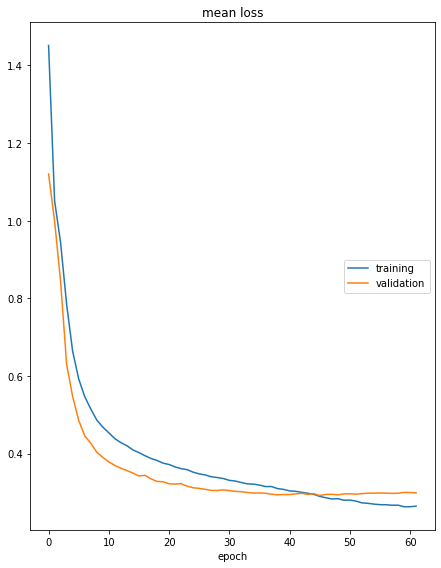

mean loss
	training         	 (min:    0.263, max:    1.452, cur:    0.264)
	validation       	 (min:    0.292, max:    1.120, cur:    0.299)
The model has not improved over the last 15 epochs, stop training


In [31]:
lr_scheduler = lambda optim: \
    torch.optim.lr_scheduler.ReduceLROnPlateau(optim, patience=5, factor=0.5, verbose=True)

#lr_scheduler = lambda optim: \
#    torch.optim.lr_scheduler.StepLR(optim, step_size=5, gamma=0.9)

best_val_loss, best_model = train_eval_loop(model,
                                            train_dataset,
                                            val_dataset,
                                            batch_nllloss,
                                            lr=5e-4,
                                            epoch_n=1000,
                                            batch_size_train=batch_size_train,
                                            batch_size_val=batch_size_val,
                                            early_stopping_patience=15,
                                            lr_scheduler_ctor=lr_scheduler,
                                            draw_loss=True,
                                            show_bar=False,
                                            dataloader_workers_n=5)

## Some examples:

In [34]:
size_for_demonstrate = 5
demonstrative_dataset = Subset(val_dataset, indices=np.random.choice(len(val_dataset), size_for_demonstrate))
demonstrative_tags_pred = predict_tags_on_tokenized_dataset(best_model, demonstrative_dataset)

In [35]:
for i in range(size_for_demonstrate):
    recipe, tags = demonstrative_dataset[i]
    
    print('Ground truth')
    show_markup(converter.indices_to_words(recipe), converter.indices_to_tags(tags), palette_set)

    print('Prediction:')
    show_markup(converter.indices_to_words(recipe), converter.indices_to_tags(demonstrative_tags_pred[i]), palette_set)
    
    print()

Ground truth


Prediction:



Ground truth


Prediction:



Ground truth


Prediction:



Ground truth


Prediction:



Ground truth


Prediction:


## Statistics on validation set:

### [Number of correctly predicted tags](#scrollTo=Nv4jBayGEtL9&line=1&uniqifier=1):

In [36]:
val_tags_pred = predict_tags_on_tokenized_dataset(best_model, val_dataset, device=None, batch_size=2991)

In [37]:
total_val_correct, total_val_tags = tag_statistics(val_dataset, val_tags_pred)

In [38]:
print_statistics(converter, total_val_correct, total_val_tags)

Statistics for correctly predicted tags:

for ['B-QTY']:
  correct:	 12583
      total:	 12726
% correct:	 98.87631620304887

for ['B-UNIT']:
  correct:	 10751
      total:	 10837
% correct:	 99.20642244163514

for ['B-NAME']:
  correct:	 13996
      total:	 15632
% correct:	 89.53428863868986

for ['I-NAME']:
  correct:	 6813
      total:	 8851
% correct:	 76.97435318043159

for ['OTHER']:
  correct:	 4675
      total:	 6038
% correct:	 77.42630009937065

for ['B-COMMENT']:
  correct:	 10573
      total:	 11878
% correct:	 89.01330190267723

for ['I-COMMENT']:
  correct:	 20528
      total:	 21978
% correct:	 93.4024934024934

for ['B-RANGE_END']:
  correct:	 206
      total:	 216
% correct:	 95.37037037037037

----------
in sum:
  correct:	 80125
      total:	 88156
% correct:	 90.89001315849177


### [Confusion Matrix](#scrollTo=Cs9va9PQEzNP&line=1&uniqifier=1):

In [39]:
y_pred = []
y_true = []

for i in range(len(val_dataset)):
    _, tags = val_dataset[i]
    y_pred += converter.indices_to_tags(val_tags_pred[i])
    y_true += converter.indices_to_tags(tags)

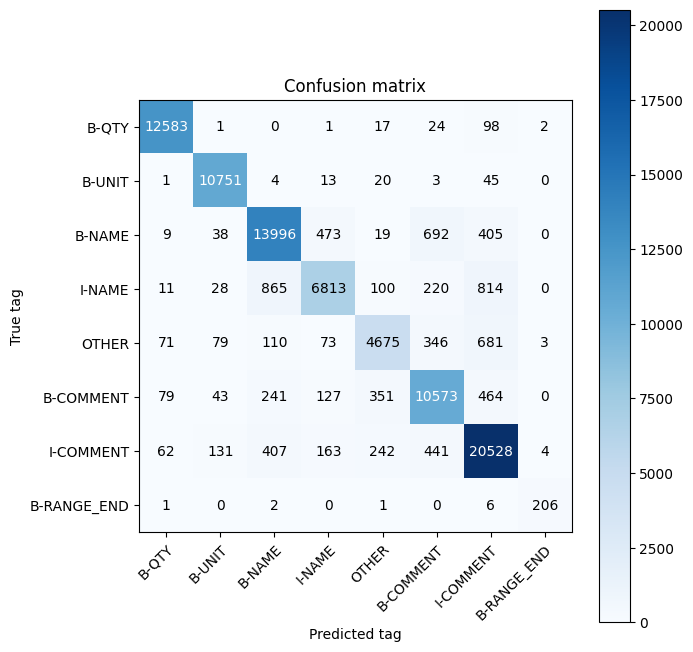

In [49]:
plot_confusion_matrix(y_true, y_pred, classes=converter.indices_to_tags(total_val_tags.keys()), title='Confusion matrix')

plt.show()

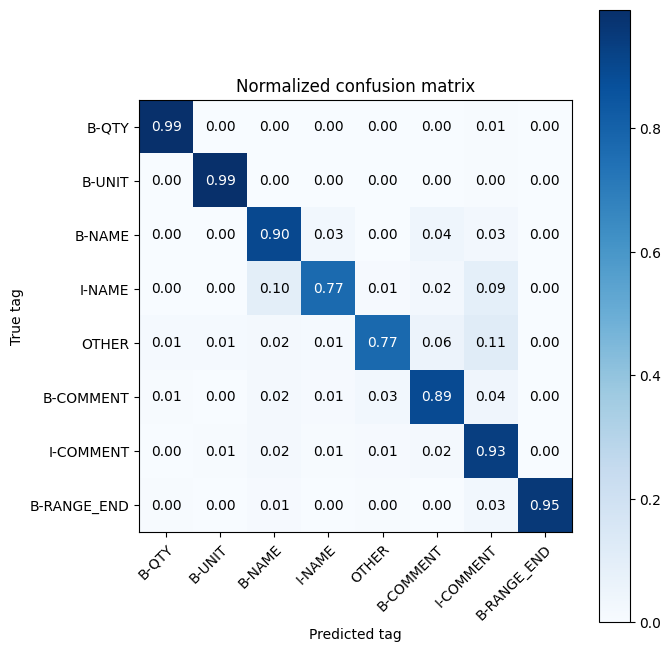

In [54]:
plot_confusion_matrix(y_true, y_pred, classes=converter.indices_to_tags(total_val_tags.keys()), normalize=True, 
                      title='Normalized confusion matrix')

plt.show()

### [Number of correctly predicted recipes](#scrollTo=yCcfVagVEvIH&line=1&uniqifier=1):

In [42]:
correct_recipes, total_recipes = recipe_statistics(val_dataset, val_tags_pred, 4)

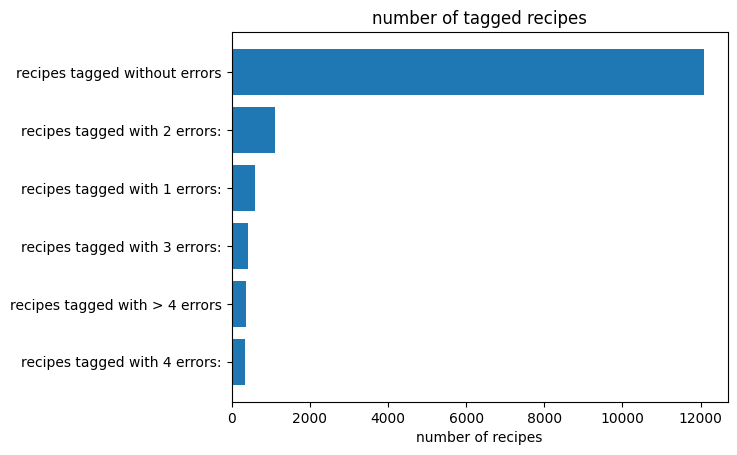

In [55]:
plot_recipe_statistics(correct_recipes)

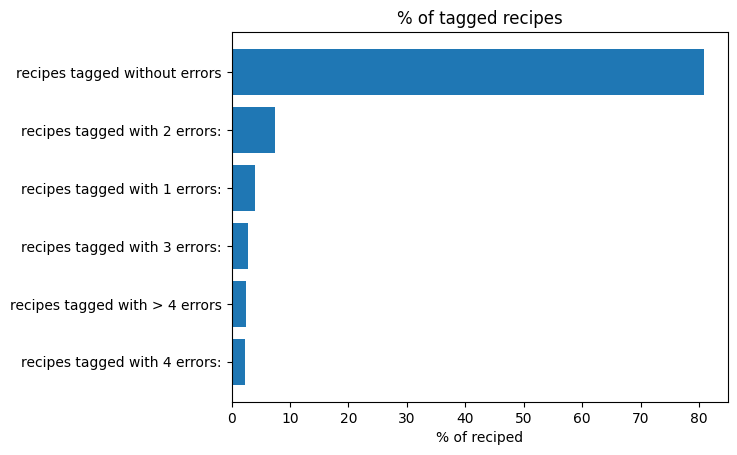

In [44]:
plot_recipe_statistics(correct_recipes, total_recipes)